In [1]:
import numpy as np 
import random 
import matplotlib.pyplot as plt  
%matplotlib inline  
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import gate 
from qiskit.quantum_info import random_statevector 
from qiskit.aqua.components.optimizers import COBYLA, ADAM 
from qiskit.compiler import transpile 


In [2]:
def random_circuit():
    state = random_statevector(4)
    qc = QuantumCircuit(4,4)
    qc.initialize(state.data, [0,3])
    return qc

In [3]:
def layer(circuit,theta_params):
    circuit.rx(theta_params[0],0)
    circuit.rx(theta_params[1],1)
    circuit.rx(theta_params[2],2)
    circuit.rx(theta_params[3],3)
    circuit.ry(theta_params[4],0)
    circuit.ry(theta_params[5],1)
    circuit.ry(theta_params[6],2)
    circuit.ry(theta_params[7],3)
    circuit.cz(0,1)
    circuit.cz(0,2)
    circuit.cz(0,3)
    circuit.cz(1,2)
    circuit.cz(1,3)
    circuit.cz(2,3)
    return circuit

In [4]:
def layer_calculation(circuit,params):
    for i in range(0,len(params), 8):
        circuit = layer(circuit,params[i:i+8])
    return circuit

In [5]:
def construct_circuit(params):
    circuit = QuantumCircuit(4)
    circuit = layer_calculation(circuit,params)
    return circuit

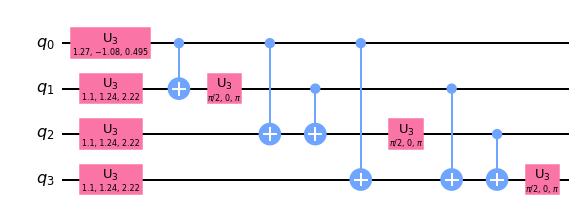

In [6]:
x = construct_circuit([1]*8)
x.draw(output='mpl')

In [7]:
def run_circuit(circuit,simulator= Aer.get_backend('statevector_simulator'), number_of_shots=100):
    job = execute(circuit, simulator, shots=number_of_shots)            
    resultant_state = job.result().get_statevector()
    return resultant_state

In [8]:
def distance_function(circuit_state,random_state):
    state_difference = circuit_state-random_state
    distance = np.linalg.norm(state_difference,ord=2) 
    return distance

In [9]:
def cost_function(params):
    global random_state_global 
    circuit = construct_circuit(params)
    state = run_circuit(circuit, simulator)
    distance = distance_function(state,random_state_global)
    return distance 

In [10]:
def main():
    cob = COBYLA(100, tol=0.0001, rhobeg=2)
    returned_values_cobyla = []

    for number_of_layers in range (1,11):
        params = [random.uniform(0,2*np.pi) for i in range(8 * number_of_layers)]
        bounds = []
        for param in params:
            bounds.append((0, 2*np.pi)) 
        ret1 = cob.optimize(num_vars=8 * number_of_layers,
                         objective_function=cost_function,
                         initial_point=params,
                         variable_bounds=bounds)
        returned_values_cobyla.append(ret1)
 
    cobyla_results = [i[1] for i in returned_values_cobyla]
         
    return (cobyla_results)

In [13]:
simulator = Aer.get_backend('statevector_simulator')

In [14]:
random_state_global = run_circuit(random_circuit()) 
(cobyla_results) = main()

In [17]:
cobyla_results

[0.7077009593848953,
 0.6032971388805176,
 0.9061735558412193,
 0.8138624524739938,
 0.8141168394336631,
 0.8685874295645921,
 0.819514282435346,
 0.8733124047412335,
 0.8528995279756586,
 0.8739073620998202]

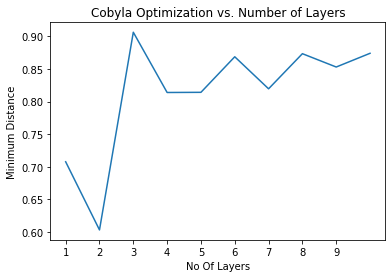

In [16]:
plt.title("Cobyla Optimization vs. Number of Layers")
plt.xlabel("No Of Layers")
plt.ylabel("Minimum Distance")
plt.xticks(np.arange(10))
plt.plot([i for i in range(1,len(cobyla_results)+1)],cobyla_results)